# Model Analysis
Now that we've trained a few different models, let's look at the performance of different hyperparameters to see where we should go from here.

In [97]:
import json
import matplotlib.pyplot as plt
%matplotlib inline

files = [
    'training_results/20230321-023258-training/training-results.json', # 64,64 - adam, 0.001, 256
    'training_results/20230321-080031-training/training-results.json', # 40,40 - adam, 0.001, 256,
    'training_results/20230321-100932-training/training-results.json', # 50, 100 - adam, 0.001, 256,
    'training_results/20230321-105038-training/training-results.json', # 8, 50 - adam, 0.001, 256,
]
offsets = [1,1,1,1,1,1,1,1]
results = []
color_map = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

for file in files:
    with open(file, 'r') as f:
        result = json.load(f)
        results.append(result)

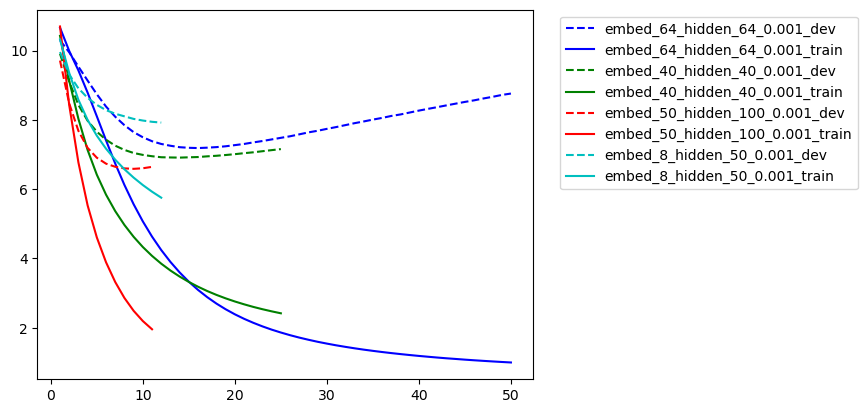

In [98]:
# plot loss vs epoch for each 
for i in range(len(files)):
    embed_size = results[i]["hyperparameters"]["EMBEDDING_LAYER_SIZE"]
    hidden_size = results[i]["hyperparameters"]["HIDDEN_SIZE"]
    lr = results[i]["hyperparameters"]["LR"]
    num_data_points = len(results[i]['elapsed_times'])
    name = f'embed_{embed_size}_hidden_{hidden_size}_{lr}'
    epoch_start = offsets[i]
    epoch_range = list(range(epoch_start, epoch_start + num_data_points))
    
    plt.plot(epoch_range, results[i]['dev_losses'], color_map[i] + '--', label=name + '_dev')
    plt.plot(epoch_range, results[i]['train_losses'], color_map[i], label=name + '_train')

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

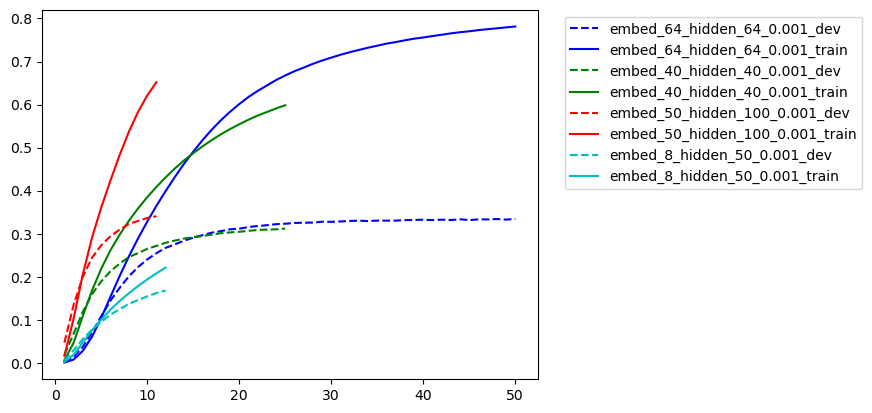

In [99]:
# plot accuracy vs epoch for each 
for i in range(len(files)):
    embed_size = results[i]["hyperparameters"]["EMBEDDING_LAYER_SIZE"]
    hidden_size = results[i]["hyperparameters"]["HIDDEN_SIZE"]
    lr = results[i]["hyperparameters"]["LR"]
    num_data_points = len(results[i]['elapsed_times'])
    name = f'embed_{embed_size}_hidden_{hidden_size}_{lr}'
    epoch_start = offsets[i]
    epoch_range = list(range(epoch_start, epoch_start + num_data_points))
    
    plt.plot(epoch_range, results[i]['dev_accu_pcts'], color_map[i] + '--', label=name + '_dev')
    plt.plot(epoch_range, results[i]['train_accu_pcts'], color_map[i], label=name + '_train')

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

So it seems that 50 dimensions and 100 neurons is our best setup so far. Interestingly 40/40 and 64/64 ended up with similar results just different training times. Leads me to believe that the ratio of embedding dimensions to neuron count is important.

## Ignore Unknown Token
We represent unknown tokens with index 0 in our answers vocabulary, but this is not something that would actually be recommended. We can ignore this when calculating loss by using the `ignore_index` parameter. Let's try that and see the results.

In [120]:
import json
import matplotlib.pyplot as plt
%matplotlib inline

files = [
    ('(50,100)', 'training_results/20230321-100932-training/training-results.json'), # 50, 100 - adam, 0.001, 256,
    ('(50,100) - ignore_index', 'training_results/20230321-113214-training/training-results.json'), # 50, 100 - adam, 0.001, 256, - with igonre_index
]
offsets = [1,1]
labels_and_results = []
color_map = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

for (label, file) in files:
    with open(file, 'r') as f:
        result = json.load(f)
        labels_and_results.append((label, result))

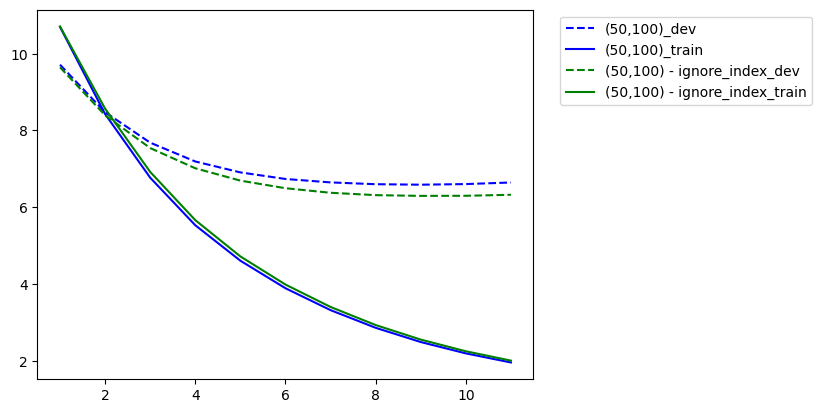

In [121]:
# plot loss vs epoch for each 
for i in range(len(files)):
    label = labels_and_results[i][0]
    result = labels_and_results[i][1]
    
    num_data_points = len(result['elapsed_times'])
    epoch_start = offsets[i]
    epoch_range = list(range(epoch_start, epoch_start + num_data_points))
    
    plt.plot(epoch_range, result['dev_losses'], color_map[i] + '--', label=label + '_dev')
    plt.plot(epoch_range, result['train_losses'], color_map[i], label=label + '_train')

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

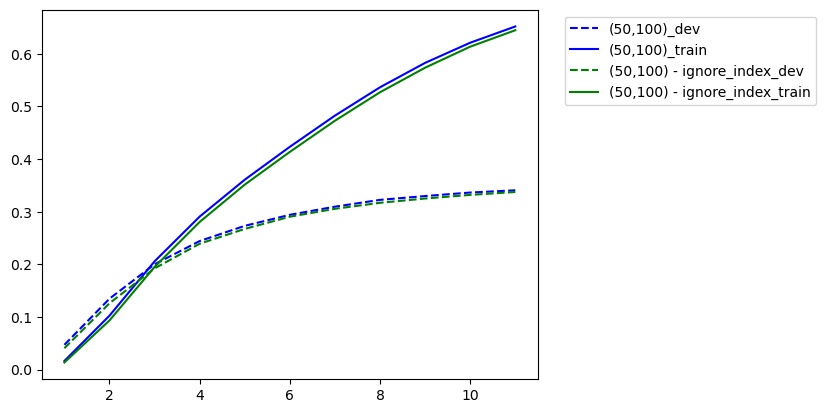

In [122]:
# plot accuracy vs epoch for each 
# plot loss vs epoch for each 
for i in range(len(files)):
    label = labels_and_results[i][0]
    result = labels_and_results[i][1]
    
    num_data_points = len(result['elapsed_times'])
    epoch_start = offsets[i]
    epoch_range = list(range(epoch_start, epoch_start + num_data_points))
    
    plt.plot(epoch_range, result['dev_accu_pcts'], color_map[i] + '--', label=label + '_dev')
    plt.plot(epoch_range, result['train_accu_pcts'], color_map[i], label=label + '_train')

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

No significant difference here. Let's keep this parameter for now since it "feels" like the right thing to do.

## Weight Decay
We can "gravitate" our output weights to be close to zero by adding a weight decay to our optimizer. It seems like the easiest way to do this in PyTorch is to use the [https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html] optimizer. 